# Variational Sparse Gaussian Process Classification (白色化あり)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

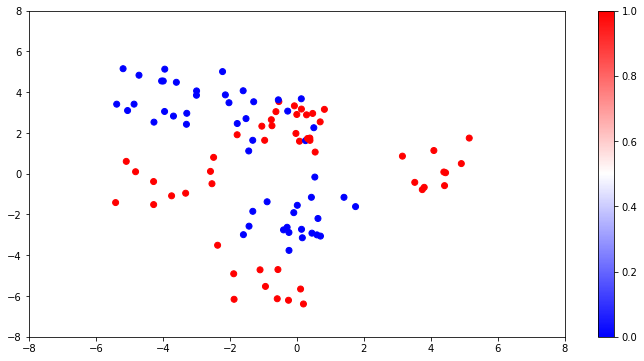

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RBF()
likelihood = Binary()
Z = X[:20, :].clone()
estimator = VSGP(Z, 1, kernel, likelihood, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    loss = svi.step(X, y)
    if epoch % (n_epochs / 10) == 0:
        print(loss)

85.6027329071542
57.411727604142285
52.52590602916022
50.29729318131888
48.04542691193855
46.512673715129026
50.203227801898294
48.0292638812028
48.215113937423034
50.34777312135758


---

## 推論結果

### 予測分布

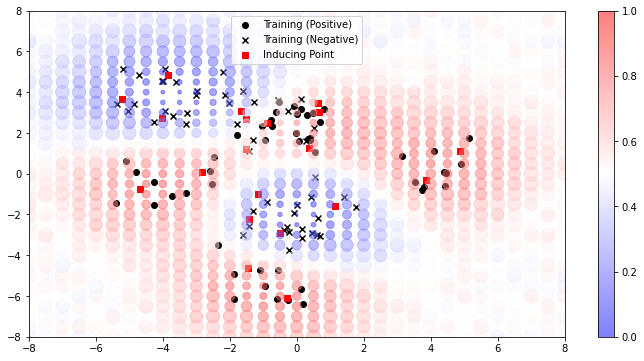

CPU times: user 20.5 s, sys: 1.45 s, total: 21.9 s
Wall time: 6.03 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)

    s = ((pnew_std - pnew_std[:, 0].min()) / pnew_std[:, 0].std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.scatter(x = Xnew[:, 0], y = Xnew[:, 1], c = pnew_mean[:, 0], s = s, marker = "o", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.scale

tensor(1.7028, grad_fn=<AddBackward0>)

### 変分パラメーター

In [11]:
estimator.Z

Parameter containing:
tensor([[-0.8812,  2.4909],
        [-5.2237,  3.6531],
        [ 4.8815,  1.1151],
        [-1.5154,  1.1889],
        [-2.8318,  0.0959],
        [-4.0280,  2.7323],
        [-1.4482, -4.6371],
        [-1.1550, -1.0157],
        [ 0.6744,  3.0269],
        [-1.4403, -2.2077],
        [ 0.6210,  3.4683],
        [-3.8591,  4.8641],
        [ 3.8523, -0.3280],
        [-1.6703,  3.0723],
        [-4.6980, -0.7484],
        [-1.5084,  2.6833],
        [-0.2786, -6.0903],
        [ 1.1479, -1.5814],
        [ 0.3534,  1.2718],
        [-0.5100, -2.8965]], requires_grad=True)

In [12]:
estimator.u_loc

Parameter containing:
tensor([[ 0.4068, -1.6647,  1.3491,  0.2039,  1.1969, -1.0426,  0.8500, -2.0440,
          1.1464, -0.6791, -0.8296, -1.1989,  0.6289, -0.9105,  0.6842,  0.0810,
          1.0531, -1.4565,  0.3241, -1.0042]], requires_grad=True)

In [13]:
estimator.u_cov

tensor([[[ 1.9861e-01, -1.6644e-02, -4.3465e-02, -1.1623e-02, -4.3177e-02,
          -7.2215e-03,  1.0879e-02,  7.0394e-03, -1.1979e-01,  6.4344e-03,
          -8.1927e-03, -1.8037e-02, -4.7866e-03, -6.5463e-02,  4.0668e-03,
          -2.0584e-03,  1.6033e-02,  1.6773e-02, -4.4663e-02,  3.9416e-02],
         [-1.6644e-02,  7.3403e-01, -2.4556e-02, -8.9568e-02, -3.0334e-02,
          -1.3522e-01, -1.0633e-01, -9.0432e-03,  3.1513e-02,  5.1539e-02,
          -4.7639e-02, -9.6132e-02, -9.0020e-02,  3.3994e-02, -5.4487e-02,
           1.6753e-02, -6.0392e-02, -1.2875e-01,  6.1042e-03, -1.0223e-02],
         [-4.3465e-02, -2.4556e-02,  5.7537e-01,  1.4836e-01, -4.0929e-02,
           1.2120e-02,  7.2774e-03,  6.2132e-02,  4.5982e-02, -2.1775e-03,
           9.6592e-02, -4.9740e-02, -1.0655e-01, -3.9974e-02,  4.1474e-02,
           1.0754e-02,  3.5150e-02,  3.6456e-02, -9.8490e-02,  4.2030e-02],
         [-1.1623e-02, -8.9568e-02,  1.4836e-01,  6.2365e-01, -1.3345e-01,
          -5.4185e-02,